In [1]:
"""
Visualize convolution layers of JTE607_CNN-DLinstance-logratio_25nt_mixedsort-4120-batchnorm-07-25-2022-6epoch_x10.ipynb
Trial 6 with all data performed the best, so visualizing its layers here

Based off of APARENT code
https://nbviewer.org/github/johli/aparent/blob/master/analysis/analyze_aparent_conv_layers_alien1_legacy.ipynb
"""

from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
"""
Code copied from here, and slightly modified:
https://github.com/johli/aparent/blob/master/analysis/analyze_aparent_conv_layers_helpers.py
"""
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Sequence Plotting Functions

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    fp = FontProperties(family="Ubuntu", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p



def plot_pwm_iso_logo(pwms, r_vals, k, logo_ax, corr_ax, seq_start=4, seq_end=101, SVLst_cs_start=49) :
    #Make sequence logo
    pwm = pwms[k]
    
    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    height_base = 0.0
    logo_height = 1.0
    
    for j in range(pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, logo_ax, color=None)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, logo_ax, color=None)

    plt.sca(logo_ax)
    plt.xlim((0, pwm.shape[0]))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    logo_ax.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)
    
    #Make correlation map
    r_val_vec = r_vals[k, seq_start: seq_end].reshape(1, -1)
    corr_ax.imshow(r_val_vec, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(r_vals[:, seq_start: seq_end])), vmax=np.max(np.abs(r_vals[:, seq_start: seq_end])))

    plt.sca(corr_ax)
    plt.xticks([SVLst_cs_start - seq_start], ['Start of SVLst designed cut site'], fontsize=12)
    plt.yticks([], [])



In [3]:
"""
Load data
"""

output_data_dir = "/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-L3only/data_splits/"
output_fig_dir = "/JTE-607/Analysis/Figures/Revisions_1/JTE607_CNN_25nt_6epoch_4col_model-L3only_4/"

data_train_x = pickle.load(open(output_data_dir + "seq_e_train.p", "rb"))
#data_train_y = pickle.load(open(output_data_dir + "res_train.p", "rb"))
#data_test_x = pickle.load(open(output_data_dir + "seq_e_test.p", "rb"))
#data_test_y = pickle.load(open(output_data_dir + "res_test.p", "rb"))


In [6]:
"""
Load best performing model with all data
"""

all_doses_trial_num = 4
models_dir = "/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-L3only/"
C3P0_ratios_model_L3only = load_model("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (models_dir, all_doses_trial_num))


In [7]:
print(C3P0_ratios_model_L3only.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 25, 120)           3960      
_________________________________________________________________
batch_normalization_24 (Batc (None, 25, 120)           480       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 25, 120)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 25, 120)           115320    
_________________________________________________________________
batch_normalization_25 (Batc (None, 25, 120)           480       
_________________________________________________________________
re_lu_19 (ReLU)              (None, 25, 120)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 25, 120)          

In [8]:
print(C3P0_ratios_model_L3only.inputs)
print(C3P0_ratios_model_L3only.get_layer("conv1d_18"))
print(C3P0_ratios_model_L3only.get_layer("re_lu_18"))

[<tf.Tensor 'conv1d_18_input_1:0' shape=(None, 25, 4) dtype=float32>]


In [9]:
"""
Create new model that outputs the convolutional layer 1 activation maps together with the log(ratio) predictions
"""

conv_layer_logratio_model = Model(
    inputs = C3P0_ratios_model_L3only.inputs,
    outputs = [
        C3P0_ratios_model_L3only.get_layer('conv1d_18').output,
        C3P0_ratios_model_L3only.get_layer('dense_13').output
    ]
)

In [10]:
"""
Predict using convolutional layer activation model
"""
#Retrieve one-hot input sequences
onehot_seqs = data_train_x

ratio_conv_1_out, ratio_pred = conv_layer_logratio_model.predict(onehot_seqs, workers=4, use_multiprocessing=True)

print(ratio_conv_1_out.shape)

ratio_conv_1_out = np.reshape(ratio_conv_1_out, (ratio_conv_1_out.shape[0], ratio_conv_1_out.shape[1], ratio_conv_1_out.shape[2]))

print(onehot_seqs.shape)
print(ratio_pred)
print(ratio_conv_1_out.shape)

(156238, 25, 120)
(156238, 25, 4)
[[-0.39632505 -0.7315455  -1.0911536 ]
 [ 0.09877834  0.33890438  0.45919478]
 [-0.15415594 -0.4515069  -0.81358314]
 ...
 [ 0.19295941  0.4627296   0.80572885]
 [-0.13284785 -0.19955947 -0.42832533]
 [-0.00432266 -0.05752337 -0.1984891 ]]
(156238, 25, 120)


In [11]:
#Layer 1: Compute Max Activation Correlation maps and PWMs, handle border_mode=same
filter_width = 8
n_samples = 5000

pwms = np.zeros((ratio_conv_1_out.shape[2], filter_width, 4))  # <num filters, filter_len, 4 nts>
pwms_top = np.zeros((ratio_conv_1_out.shape[2], filter_width, 4))

print("pwms.shape = ", pwms.shape)
print("onehot_seqs.shape = ", onehot_seqs.shape)
print("ratio_conv_1_out.shape = ", ratio_conv_1_out.shape)

filler_5 = np.zeros((3, 4))
filler_3 = np.zeros((4, 4))

for k in range(ratio_conv_1_out.shape[2]) :  # iterate over filters
    
    for i in range(ratio_conv_1_out.shape[0]) :  # iterate over samples
        max_j = np.argmax(ratio_conv_1_out[i, :, k])  # find max activation in seq
        if ratio_conv_1_out[i, max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[i, :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j : max_j + filter_width, :]
            pwms[k, :, :] += subseq_one_hot

    sort_index = np.argsort(np.max(ratio_conv_1_out[:, :, k], axis=-1))[::-1]
    for i in range(n_samples) :  # iterate over samples that have been sorted
        max_j = np.argmax(ratio_conv_1_out[sort_index[i], :, k])
        if ratio_conv_1_out[sort_index[i], max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[sort_index[i], :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j: max_j+filter_width, :]
            
            pwms_top[k, :, :] += subseq_one_hot
        
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

#print("pwms = ", pwms)
print("pwms.shape = ", pwms.shape)
print("(pwms == pwms_top).all() = ", (pwms == pwms_top).all())


r_vals_12p5 = np.zeros((ratio_conv_1_out.shape[2], ratio_conv_1_out.shape[1]))
r_vals_2p5 = np.zeros((ratio_conv_1_out.shape[2], ratio_conv_1_out.shape[1]))
r_vals_0p5 = np.zeros((ratio_conv_1_out.shape[2], ratio_conv_1_out.shape[1]))

for k in range(ratio_conv_1_out.shape[2]) :  # filters
    for j in range(ratio_conv_1_out.shape[1]) :  # sequence
        if np.any(ratio_conv_1_out[:, j, k] > 0.) :
            r_val_12p5, _ = pearsonr(ratio_conv_1_out[:, j, k], ratio_pred[:,2])
            r_vals_12p5[k, j] = r_val_12p5 if not np.isnan(r_val_12p5) else 0
            r_val_2p5, _ = pearsonr(ratio_conv_1_out[:, j, k], ratio_pred[:,1])
            r_vals_2p5[k, j] = r_val_2p5 if not np.isnan(r_val_2p5) else 0
            r_val_0p5, _ = pearsonr(ratio_conv_1_out[:, j, k], ratio_pred[:,0])
            r_vals_0p5[k, j] = r_val_0p5 if not np.isnan(r_val_0p5) else 0

pwms.shape =  (120, 8, 4)
onehot_seqs.shape =  (156238, 25, 4)
ratio_conv_1_out.shape =  (156238, 25, 120)
pwms.shape =  (120, 8, 4)
(pwms == pwms_top).all() =  False


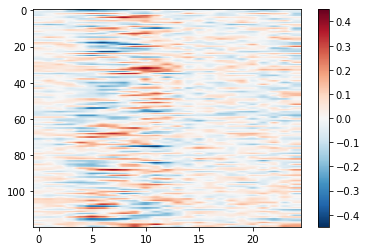

r_vals_12p5_max.head(20) =              0         1         2         3         4         5         6  \
75  -0.017476 -0.029890 -0.014447  0.056962  0.131193  0.130784  0.006146   
32   0.050194  0.072208  0.051239  0.033901  0.056768  0.057425 -0.005396   
88   0.057707  0.051543 -0.004490 -0.019462  0.019535  0.180529  0.362796   
108  0.004720  0.065368  0.104164 -0.018935 -0.203641 -0.400259 -0.417829   
23  -0.007316 -0.024235 -0.039291 -0.091579 -0.135104 -0.244957 -0.412515   
18   0.106497  0.098655  0.071241 -0.061648 -0.176433 -0.337836 -0.407200   
10  -0.026045 -0.039499 -0.019994 -0.074605  0.009889  0.170841  0.252131   
4    0.032461  0.013165 -0.042860 -0.122385 -0.063634  0.085214  0.245598   
84  -0.047401  0.023277 -0.041614 -0.071712 -0.090779 -0.157353 -0.139372   
54  -0.030796  0.043912  0.016851 -0.091154 -0.200057 -0.367744 -0.329319   
19   0.040684  0.035487  0.107331  0.096508  0.020850 -0.022951 -0.060274   
115 -0.015223  0.019011  0.033239 -0.042979 -0.2

In [12]:
"""
Layer 1:
Plot R^2 of 12.5 uM dataset and get colorbar which is the same scale as above logos.
Show plot number of the highest correlation filters under "original_order"
"""
plt.imshow(r_vals_12p5, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(r_vals_12p5)), vmax=np.max(np.abs(r_vals_12p5)))
plt.colorbar()
#plt.savefig("%s/r_vals_12p5_layer1.pdf" % (output_fig_dir))
plt.show()

r_vals_12p5_max = pd.DataFrame(r_vals_12p5)
r_vals_12p5_max["max"] = np.amax(abs(r_vals_12p5), axis=1)
r_vals_12p5_max["original_order"] = range(len(r_vals_12p5_max))
r_vals_12p5_max = r_vals_12p5_max.sort_values(by=['max'], ascending=False)
print("r_vals_12p5_max.head(20) = ", r_vals_12p5_max.head(20))


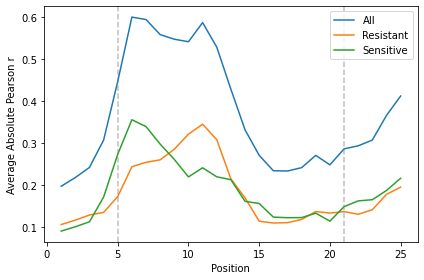

In [14]:
r_vals_12p5_pos_sum = abs(r_vals_12p5).sum(axis=0).reshape(25,1)
r_vals_12p5_pos_avg = r_vals_12p5_pos_sum /25
r_vals_12p5_pos_avg_df = pd.DataFrame(r_vals_12p5_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_pos_avg_df["Position"] = range(1, len(r_vals_12p5_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_resistant_pos_avg = r_vals_12p5.copy()
r_vals_12p5_resistant_pos_avg[r_vals_12p5_resistant_pos_avg < 0] = 0
r_vals_12p5_resistant_pos_avg = r_vals_12p5_resistant_pos_avg.sum(axis=0).reshape(25,1) / 25
r_vals_12p5_resistant_pos_avg_df = pd.DataFrame(r_vals_12p5_resistant_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_resistant_pos_avg_df["Position"] = range(1, len(r_vals_12p5_resistant_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_resistant_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_sensitive_pos_avg = r_vals_12p5.copy()
r_vals_12p5_sensitive_pos_avg[r_vals_12p5_sensitive_pos_avg > 0] = 0
r_vals_12p5_sensitive_pos_avg = abs(r_vals_12p5_sensitive_pos_avg).sum(axis=0).reshape(25,1) / 25
r_vals_12p5_sensitive_pos_avg_df = pd.DataFrame(r_vals_12p5_sensitive_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_sensitive_pos_avg_df["Position"] = range(1, len(r_vals_12p5_sensitive_pos_avg_df.index) + 1)

sns.lineplot(data=r_vals_12p5_sensitive_pos_avg_df, x="Position", y="Average Absolute Pearson r")

plt.legend(labels=["All", "Resistant", "Sensitive"])
plt.axvline(x=5, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=21, linestyle="dashed", color="gray", alpha=0.5)
plt.tight_layout()
plt.savefig("%s/r_vals_avg_abs_12p5_layer1.pdf" % (output_fig_dir))
plt.show()

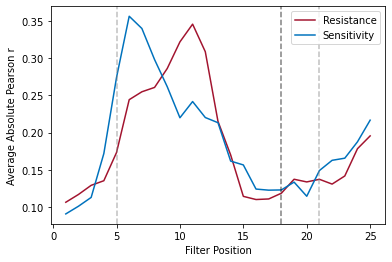

In [15]:
r_vals_12p5_resistant_pos_avg = r_vals_12p5.copy()
r_vals_12p5_resistant_pos_avg[r_vals_12p5_resistant_pos_avg < 0] = 0
r_vals_12p5_resistant_pos_avg = r_vals_12p5_resistant_pos_avg.sum(axis=0).reshape(25,1) / 25
r_vals_12p5_resistant_pos_avg_df = pd.DataFrame(r_vals_12p5_resistant_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_resistant_pos_avg_df["Filter Position"] = range(1, len(r_vals_12p5_resistant_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_resistant_pos_avg_df, x="Filter Position", y="Average Absolute Pearson r", color="#A2142F")

r_vals_12p5_sensitive_pos_avg = r_vals_12p5.copy()
r_vals_12p5_sensitive_pos_avg[r_vals_12p5_sensitive_pos_avg > 0] = 0
r_vals_12p5_sensitive_pos_avg = abs(r_vals_12p5_sensitive_pos_avg).sum(axis=0).reshape(25,1) / 25
r_vals_12p5_sensitive_pos_avg_df = pd.DataFrame(r_vals_12p5_sensitive_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_sensitive_pos_avg_df["Filter Position"] = range(1, len(r_vals_12p5_sensitive_pos_avg_df.index) + 1)

sns.lineplot(data=r_vals_12p5_sensitive_pos_avg_df, x="Filter Position", y="Average Absolute Pearson r", color="#0072BD")

plt.legend(labels=["Resistance", "Sensitivity"], loc="upper right")
plt.axvline(x=5, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=21, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=18, linestyle="dashed", color="black", alpha=0.5)
plt.savefig("%s/r_vals_avg_abs_12p5_layer1_resistance_sensitivity.pdf" % (output_fig_dir))
plt.show()

In [16]:
"""
Create new model that outputs the convolutional layer 2 activation maps together with the log(ratio) predictions
"""

conv_layer_logratio_layer2_model = Model(
    inputs = C3P0_ratios_model_L3only.inputs,
    outputs = [
        C3P0_ratios_model_L3only.get_layer('conv1d_19').output,
        C3P0_ratios_model_L3only.get_layer('dense_13').output
    ]
)

In [17]:
"""
Predict from convolutional layer 2 activation maps model
"""

#Retrieve one-hot input sequences

ratio_conv_2_out, ratio_pred = conv_layer_logratio_layer2_model.predict(onehot_seqs, workers=4, use_multiprocessing=True)

print(ratio_conv_2_out.shape)

ratio_conv_2_out = np.reshape(ratio_conv_2_out, (ratio_conv_2_out.shape[0], ratio_conv_2_out.shape[1], ratio_conv_2_out.shape[2]))

print(onehot_seqs.shape)
print(ratio_pred)
print(ratio_conv_2_out.shape)


(156238, 25, 120)
(156238, 25, 4)
[[-0.39632505 -0.7315455  -1.0911536 ]
 [ 0.09877834  0.33890438  0.45919478]
 [-0.15415594 -0.4515069  -0.81358314]
 ...
 [ 0.19295941  0.4627296   0.80572885]
 [-0.13284785 -0.19955947 -0.42832533]
 [-0.00432266 -0.05752337 -0.1984891 ]]
(156238, 25, 120)


In [18]:
#Layer 2: Compute Max Activation Correlation maps and PWMs, handle border_mode=same, 8 nt padding
filter_width = 15  # 8 + 8 - 1
n_samples = 5000

pwms = np.zeros((ratio_conv_2_out.shape[2], filter_width, 4))  # <num filters, filter_len, 4 nts>
pwms_top = np.zeros((ratio_conv_2_out.shape[2], filter_width, 4))

print("pwms.shape = ", pwms.shape)
print("onehot_seqs.shape = ", onehot_seqs.shape)
print("ratio_conv_2_out.shape = ", ratio_conv_2_out.shape)

filler_5 = np.zeros((7, 4))  # layer 1 filter length of 8 / 2 * 2
filler_3 = np.zeros((8, 4))  # layer 1 filter length of 8 / 2 * 2

for k in range(ratio_conv_2_out.shape[2]) :  # iterate over filters
    
    for i in range(ratio_conv_2_out.shape[0]) :  # iterate over samples
        max_j = np.argmax(ratio_conv_2_out[i, :, k])  # find max activation in seq
        if ratio_conv_2_out[i, max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[i, :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j : max_j + filter_width, :]
            pwms[k, :, :] += subseq_one_hot

    sort_index = np.argsort(np.max(ratio_conv_2_out[:, :, k], axis=-1))[::-1]
    for i in range(n_samples) :  # iterate over samples that have been sorted
        max_j = np.argmax(ratio_conv_2_out[sort_index[i], :, k])
        if ratio_conv_2_out[sort_index[i], max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[sort_index[i], :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j: max_j+filter_width, :]
            
            pwms_top[k, :, :] += subseq_one_hot
        
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

#print("pwms = ", pwms)
print("pwms.shape = ", pwms.shape)
print("pwms_top.shape = ", pwms_top.shape)
print("(pwms == pwms_top).all() = ", (pwms == pwms_top).all())


r_vals_12p5 = np.zeros((ratio_conv_2_out.shape[2], ratio_conv_2_out.shape[1]))
r_vals_2p5 = np.zeros((ratio_conv_2_out.shape[2], ratio_conv_2_out.shape[1]))
r_vals_0p5 = np.zeros((ratio_conv_2_out.shape[2], ratio_conv_2_out.shape[1]))

for k in range(ratio_conv_2_out.shape[2]) :  # filters
    for j in range(ratio_conv_2_out.shape[1]) :  # sequence
        if np.any(ratio_conv_2_out[:, j, k] > 0.) :
            r_val_12p5, _ = pearsonr(ratio_conv_2_out[:, j, k], ratio_pred[:,2])
            r_vals_12p5[k, j] = r_val_12p5 if not np.isnan(r_val_12p5) else 0
            r_val_2p5, _ = pearsonr(ratio_conv_2_out[:, j, k], ratio_pred[:,1])
            r_vals_2p5[k, j] = r_val_2p5 if not np.isnan(r_val_2p5) else 0
            r_val_0p5, _ = pearsonr(ratio_conv_2_out[:, j, k], ratio_pred[:,0])
            r_vals_0p5[k, j] = r_val_0p5 if not np.isnan(r_val_0p5) else 0

print("r_vals_12p5.shape = ", r_vals_12p5.shape)

pwms.shape =  (120, 15, 4)
onehot_seqs.shape =  (156238, 25, 4)
ratio_conv_2_out.shape =  (156238, 25, 120)
pwms.shape =  (120, 15, 4)
pwms_top.shape =  (120, 15, 4)
(pwms == pwms_top).all() =  False
r_vals_12p5.shape =  (120, 25)


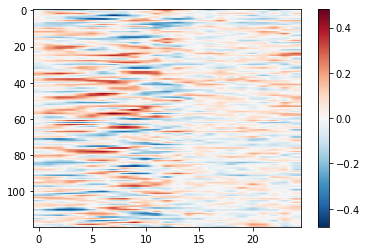

r_vals_12p5_max.head(20) =              0         1         2         3         4         5         6  \
3    0.009013  0.042613 -0.022244 -0.040297 -0.070685 -0.139755 -0.317081   
86  -0.074030 -0.106590 -0.035351  0.034343  0.083954  0.204201  0.103476   
5    0.017225 -0.036870 -0.064019 -0.171949 -0.315730 -0.446539 -0.477324   
57   0.139269  0.256989  0.207771  0.141589  0.089727  0.142404  0.346810   
55   0.021192  0.128222  0.222522  0.238793  0.107170 -0.019863 -0.109686   
76   0.150941  0.216799  0.163408 -0.009718 -0.059393  0.024182  0.252156   
110 -0.158566 -0.290759 -0.434827 -0.412572 -0.372588 -0.194895  0.008981   
32  -0.129065 -0.086827  0.024905  0.131045  0.206395  0.149279  0.083024   
60  -0.024073 -0.083982 -0.066709 -0.079596 -0.148701 -0.167949 -0.084815   
90   0.008872  0.020864 -0.000678  0.032644  0.106313  0.229874  0.235129   
46  -0.015969 -0.007698 -0.042781  0.004048  0.130248  0.298474  0.416294   
82  -0.015219  0.011395 -0.031838  0.073438  0.0

In [19]:
"""
Layer 2:
Plot R^2 of 12.5 uM dataset and get colorbar which is the same scale as above logos.
Show plot number of the highest correlation filters under "original_order"
"""
plt.imshow(r_vals_12p5, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(r_vals_12p5)), vmax=np.max(np.abs(r_vals_12p5)))
plt.colorbar()
#plt.savefig("%s/r_vals_12p5_layer2.pdf" % (output_fig_dir))
plt.show()

r_vals_12p5_max = pd.DataFrame(r_vals_12p5)
r_vals_12p5_max["max"] = np.amax(abs(r_vals_12p5), axis=1)
r_vals_12p5_max["original_order"] = range(len(r_vals_12p5_max))
r_vals_12p5_max = r_vals_12p5_max.sort_values(by=['max'], ascending=False)
print("r_vals_12p5_max.head(20) = ", r_vals_12p5_max.head(20))


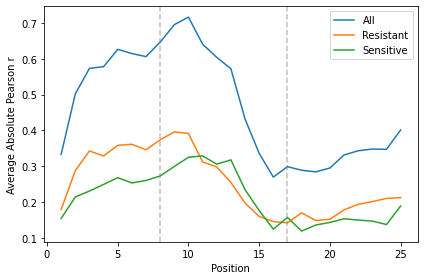

In [20]:
r_vals_12p5_pos_sum = abs(r_vals_12p5).sum(axis=0).reshape(25,1)
r_vals_12p5_pos_avg = r_vals_12p5_pos_sum /25
r_vals_12p5_pos_avg_df = pd.DataFrame(r_vals_12p5_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_pos_avg_df["Position"] = range(1, len(r_vals_12p5_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_resistant_pos_avg = r_vals_12p5.copy()
r_vals_12p5_resistant_pos_avg[r_vals_12p5_resistant_pos_avg < 0] = 0
r_vals_12p5_resistant_pos_avg = r_vals_12p5_resistant_pos_avg.sum(axis=0).reshape(25,1) / 25
r_vals_12p5_resistant_pos_avg_df = pd.DataFrame(r_vals_12p5_resistant_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_resistant_pos_avg_df["Position"] = range(1, len(r_vals_12p5_resistant_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_resistant_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_sensitive_pos_avg = r_vals_12p5.copy()
r_vals_12p5_sensitive_pos_avg[r_vals_12p5_sensitive_pos_avg > 0] = 0
r_vals_12p5_sensitive_pos_avg = abs(r_vals_12p5_sensitive_pos_avg).sum(axis=0).reshape(25,1) / 25
r_vals_12p5_sensitive_pos_avg_df = pd.DataFrame(r_vals_12p5_sensitive_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_sensitive_pos_avg_df["Position"] = range(1, len(r_vals_12p5_sensitive_pos_avg_df.index) + 1)

sns.lineplot(data=r_vals_12p5_sensitive_pos_avg_df, x="Position", y="Average Absolute Pearson r")
plt.axvline(x=8, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=17, linestyle="dashed", color="gray", alpha=0.5)
plt.legend(labels=["All", "Resistant", "Sensitive"])
plt.tight_layout()
plt.savefig("%s/r_vals_avg_abs_12p5_layer2.pdf" % (output_fig_dir))
plt.show()